# Collecting data from GooglePlay

This notebook is used to collect the dataset 'reviews.csv' using reviews from the companies Asos and Zalando.ß

The function used for scraping app info and reviews is [google-play-scraper](https://github.com/JoMingyu/google-play-scraper).

## Setup

Let's install the required packages and setup the imports:

In [ ]:
# First time running this code, you need to install package 'google_play_scraper' 
!pip install --upgrade google_play_scraper

In [2]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app


Now let's create a list of Apps we want to collect.

We will need 'the Google Play ID', which is the unique identifier of an Android application. 
It can be found by searching for the app and finding the Play store web page for the app.

In the example below, the Google Play ID is ``com.amazon.mShop.android.shopping``, which you can find directly from its url address:

https://play.google.com/store/apps/details?id=com.amazon.mShop.android.shopping

You are free to define your own list of Apps.

In [15]:
# List of Apps and their packages to be collected. Here I choose some Apps under the category 'productivity'
app_packages = [
    'com.asos.app',
    'de.zalando.mobile'
]

## Scraping App Information

Let's scrape the info for each app:

In [16]:
app_infos = []

for ap in tqdm(app_packages):
    info = app(ap, lang='en', country='uk') # from the UK markert
    del info['comments']
    app_infos.append(info)

100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Let's look at the corresponding JSON objects:

In [17]:
def print_json(json_object):
    json_str = json.dumps(
        json_object, 
        indent=2, 
        sort_keys=True, 
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [18]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "5.0",
  "androidVersionText": "5.0 and up",
  "appId": "com.asos.app",
  "containsAds": false,
  "contentRating": "PEGI 3",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Here\u2019s the situation: fresh pieces dropping daily, exclusive ranges you can't get anywhere else and new brands being added all the time \u2013 plus free delivery and returns. Wherever and whoever you are, exploring your style never felt so good.\r\n\r\nWith the ASOS app for Android, you can: \r\n\r\n- FIND & SAVE WHAT YOU WANT \r\nYou can still shop every piece you'll find on ASOS. Search by type, size, brand, price and color, or browse and buy our trend and occasion edits. Plus, your Saved Items and Shopping Bag sync between your devices, too \u2013 genius.\r\n\r\n- ENJOY SUPER-EASY CHECKOUT \r\nAdd a new credit card with our camera card scanner (#techy) for our quickest checkout ever. \r\n\r\n- GET HANDY SALE ALERTS \r\nOur push notificat

## Print Logos

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). We can select what is relevant and even some of the info we like. For example, we can print all their logos. 

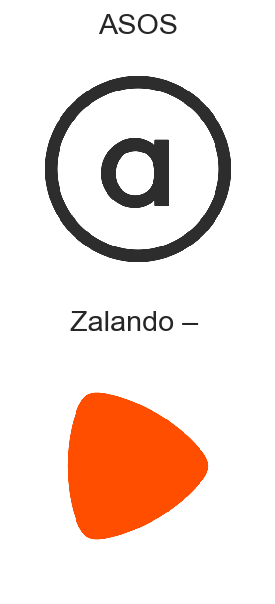

In [19]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Function to format and get the title
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

# Print logos and titles
fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    img = plt.imread(ai['icon'])
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

We'll store the app information for later by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file:

In [20]:
# App Data into Pandas DF and store it
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('./apps.csv', index=None, header=True)

## Scraping App Reviews

In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

We want:

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

See https://github.com/JoMingyu/google-play-scraper for configurations of function ``google_play_scraper.reviews``.

In [21]:
# This is an example of the function google_play_scraper.reviews
result, continuation_token = reviews(
    'com.fantome.penguinisle',
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
    count=1, # defaults to 100
    filter_score_with=5 # defaults to None(means all score)
)
result

[{'reviewId': 'gp:AOqpTOGbViDdKrBo0qwEaWDXPIH4gei7czGpxReNgUG8USDFGkp2sFZmAmPccUMagWRsPFohQzl5z63nOxOdsJ8',
  'userName': 'YURIPRIME',
  'userImage': 'https://play-lh.googleusercontent.com/a-/AOh14GgfbCCTXsRMaZrD9yERjxgaEHYqGixRcJVKy7YPPA',
  'content': "This game makes me relax and put all my problems aside and I really appreciate that. The background music, the penguins, the environment and the gameplay itself. This is the only game that makes me wanna watch all the ads just for the sake getting more stuff like free chest, multiply rewards, and other stuff. This game is really amazing ! I don't find it annoying with the ads, some ads are just straight up funny. Loved the game ! Keep up the good work.",
  'score': 5,
  'thumbsUpCount': 22,
  'reviewCreatedVersion': '1.31.4',
  'at': datetime.datetime(2021, 3, 21, 13, 50, 52),
  'replyContent': 'Thank you for your support.',
  'repliedAt': datetime.datetime(2021, 3, 21, 15, 21, 31)}]

In [22]:
app_reviews = []

# Loop through all the app packages and collect review for each of them
for ap in tqdm(app_packages):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en',
                country='uk',
                sort=sort_order,
                count= 150 if score == 3 else 200,
                filter_score_with=score
            )
        for r in rvs:
            r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
            r['appId'] = ap

        app_reviews.extend(rvs)

100%|██████████| 2/2 [00:26<00:00, 13.10s/it]


Note that we're adding the app id and sort order to each review. Here's an example for one:

In [23]:
print_json(app_reviews[0])

{
  "appId": "com.asos.app",
  "at": "2021-03-24 06:44:01",
  "content": "Doesn't let me order anything just keeps telling me order was successful and I immediately get another email saying order unsuccessful",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "4.46.0",
  "reviewId": "gp:AOqpTOECWgwZjPLvW1dxl94nbEmkNhb7wI81LW9duuzGYZA-JZxqfn8Qmw5VXBhwr1wEzsBWSZLZDFNfFZFQKQ",
  "score": 1,
  "sortOrder": "newest",
  "thumbsUpCount": 0,
  "userImage": "https://play-lh.googleusercontent.com/-lKti1p--bdY/AAAAAAAAAAI/AAAAAAAAAAA/AMZuuckgBXor30APu-iiKNCFN55_EHHGiw/photo.jpg",
  "userName": "Valeria Anguiano"
}



`repliedAt` and `replyContent` contain the developer response to the review.

So, how many app reviews did we get?



In [24]:
print("We were able to scrap: ", len(app_reviews), " reviews")

We were able to scrap:  1881  reviews


Let's save the reviews to a CSV file:

In [25]:
# Save app reviews in a CSV format
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('./reviews.csv', index=None, header=True)

In [26]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOECWgwZjPLvW1dxl94nbEmkNhb7wI81LW9duuz...,Valeria Anguiano,https://play-lh.googleusercontent.com/-lKti1p-...,Doesn't let me order anything just keeps telli...,1,0,4.46.0,2021-03-24 06:44:01,None,NaT,newest,com.asos.app
1,gp:AOqpTOGxAsJGwnh_FuPF2-WIaozOxkJlUNKhjDm9v6R...,Igor T,https://play-lh.googleusercontent.com/a-/AOh14...,Charged me the money and said they shipped the...,1,0,4.46.0,2021-03-23 21:12:48,None,NaT,newest,com.asos.app
2,gp:AOqpTOFhzKoXP4gtMUoYmG7qu2yOLS1Hz7d4rAGbqrS...,Fred Saimpre,https://play-lh.googleusercontent.com/a-/AOh14...,I used to enjoy shopping on this app. It's unf...,1,2,4.46.0,2021-03-23 03:50:12,None,NaT,newest,com.asos.app
3,gp:AOqpTOF4blkO0yXldS98RYRwxIQimhBuA74zb9S27Rt...,anisaba2,https://play-lh.googleusercontent.com/-tV40baf...,The quality of their cloths is amazing. Howeve...,1,38,4.46.0,2021-03-21 18:21:19,None,NaT,newest,com.asos.app
4,gp:AOqpTOHOM6J9YNXJNyOqS_Qmsot9BiTTjUjXNe69E6D...,anjali rawat,https://play-lh.googleusercontent.com/-gU-xlFq...,Its all good till you place the order but a co...,1,1,4.45.0,2021-03-20 20:30:08,None,NaT,newest,com.asos.app
